# Validation test

Now we apply some geometrical arguments to test if our view of functions as directions in state-space actually holds for this particular dataset. If this test is successful then we can dive deeper into the data with confidence. First we'll load the packages we need and we'll load the data that we prepared in the previous chapter of the tutorial. 

In [1]:
import pandas as pd                  # general data organisation         
import numpy as np                   # general work with matrices and vectors 
from numpy.linalg import norm, inv   # matrix tools
import matplotlib.pyplot as plt      # general plotting work

# for text formating in figures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",  
})

# loading the data and saving a colour
grasslands = pd.read_csv("data/grasslands.csv", index_col="Observation")
mismatch_matrix = pd.read_csv("data/mismatch_matrix.csv", index_col="Unnamed: 0")
grass_col = '#b89247'

```{eval-rst}
.. note::

   The matrix of mismatches that we'll use for this validation test only contains ecosystem functions and not diversity metrics. Gradients of diversity metrics are state-dependent so we can't treat them as fixed directions in state-space across different experiments, which is the approach we take for the ecosystem functions in this validation test. 
   
.. include:: ./include-rst.rst
```

## Test: Linear Combinations

First, we assume that the proportion of mismatches between two functions can be equated to their collinearity:

$$\mathbb{P}(Mismatch)=\frac{\theta}{\pi}$$

where $\theta$ is the angle between the two functions, which we sometimes refer to as their collinearity (or their similarity). In this test we try to predict the collinearity of two given functions using the collinearity of all other pairs of functions.

To gain an intuitive understanding of this test, consider the four functions A-D in the Figure below. This test is asking: if $\theta_{AB}$ is unknown, but we know the other five angles, can we put these functions together like pieces of a jigsaw to reconstruct $\theta_{AB}$? 

:::{figure-md} markdown-fig
<img src="images/linear_combinations.png" alt="linear-combinations" class="bg-primary mb-1" width="60%">

Can the collinearity between functions A and B be reconstructed using the collinearity of all other pairs of functions? 
:::


In the code below we will first define `Cos_data` as the "true" collinearity of functions based on their mismatches with each other. We will then estimate `Cos_hat`, the collinearity of functions based on the collinearity of all other pairs of functions.

In [4]:
# Cos_data, actual collinearity of functions based their proportion of mismatches
Pij=mismatch_matrix.values[:,:]                  
K=len(Pij[0:])
Cos_data=np.zeros([K,K])
for i in range(K):
    for j in range(K):
        Cos_data[i,j]=np.cos(Pij[i,j]*np.pi)     

# Cos_hat, theoretical prediction for the collinearity of functions based on all other collinearities
Norm=np.zeros([K,K]) 
Cos_hat=np.zeros([K,K])  
for i in range(K):
    for j in range(K):
        Cij=np.delete(np.delete(Cos_data,[i,j],0),[i,j],1)
        R=inv(Cij)
        Norm[i,j]=norm(R)
        u=np.delete(Cos_data[i,:],[i,j])
        v=np.delete(Cos_data[j,:],[i,j])
        Cos_hat[i,j]=np.dot(np.dot(R,u),v)
        up=np.delete(Pij[i,:],[i,j])
        vp=np.delete(Pij[j,:],[i,j])
        
cos=np.ravel(Cos_data)    # ground truth
cos_hat=np.ravel(Cos_hat) # prediction
normM=np.ravel(Norm)      # sensitivity

Now we can plot `Cos_data` (ground trut collinearity) against `Cos_hat` (theoretical prediction). 

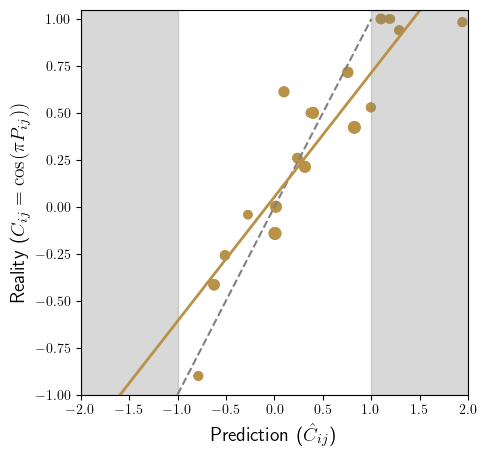

In [5]:
roof=15 # upper bound on sensitivity - if the norm is too high this process won't work

# Plot the prediction against the empirical results (scale points by Norm - larger points with lower norms, more accurate)
plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')

plt.scatter(cos_hat[normM<roof],cos[normM<roof],s=500/normM[normM<roof], color = grass_col)
plt.plot([-1,1],[-1,1],'--', color = (0.5, 0.5, 0.5))
plt.fill_between([1,2],[-1,-1],[1.05,1.05],color=(0.5, 0.5, 0.5),alpha=0.3)
plt.fill_between([-2,-1],[-1,-1],[1.05,1.05],color=(0.5, 0.5, 0.5),alpha=0.3)

plt.xlabel('Prediction ($\hat{C}_{ij}$)',fontsize=14)
plt.ylabel('Reality ($C_{ij}=\cos(\pi P_{ij}))$',fontsize=14)
plt.ylim(-1,1.05)
plt.xlim(-2,2)

# linear fit
x=np.concatenate([cos_hat[normM<roof],cos_hat[normM<roof]])
y=np.concatenate([cos[normM<roof],cos[normM<roof]])
lin=np.polyfit(x,y,1)
z=np.linspace(-2,2,100)
plt.plot(z,z*lin[0]+lin[1],'-',lw=2, color = grass_col);

It is very encouraging to see points falling along the 1:1 line. We made quite strong assumptions to reach our theoretical prediction, so results like this give us great confidence functions in this grasslands dataset can really be approximated by directions in state space. Now we can use our geometric approach to have a deeper dive into the empirical data in the next two chapters.  

::::{important}

This procedure involves a matrix inversion that requires the norm of the matrix not to be too large. This requires that the functions are sufficiently different from one another so that their respective directions do not too closely align. In the figure above we therefore remove predictions that came from matrices with large norms. 

::::

## What if your data don't pass the test?


You may find that running this test on your own data doesn't give such clean results. For example, if we had used data from all biomes in the Zhou et al dataset (rather than just data from grasslands) the result of our test would have looked like this: 


:::{figure-md} markdown-fig
<img src="images/all-biomes.png" alt="all-biomes" class="bg-primary mb-1" width="50%">

Linear combination test using data from all biomes
:::

If you were to find result like this, where the `Cos_data` ("true" collinearity of functions based on their mismatches with each other) is not correlated to `Cos_hat` (predicted collinearity based on the collinearity of all other pairs of functions), the first thing to do is to increase the consistency of your dataset by focusing on a subset of more similar ecosystem types.

There is a trade-off between the size and the consistency of your dataset. The more data you have, the more confident you can be with estimates for the proportion of mismatches and the more questions you can ask. However, if those data are from very different systems, assuming that functions have the same directions in state-space across all of those systems becomes unreasonable. 

It is worth pointing out, however, that this is a conservative test. Even if the functions in your dataset can actually be represented well by linear directions in state-space, the procedure of this test can itself introduce artefacts leading to noisy results. For instance, to obtain the theoretical prediciton there is a matrix inversion, which only works for functions that are sufficiently different from one another. Therefore, **if points don't fall on the 1:1 line, it doesn't necessarily mean that a geometric view of functions isn't valid**. However, if points do fall on the 1:1 line, we can certainly be very confident in this approach. 